In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from IPython.display import clear_output 
import pickle
import scipy
import cmath
import matplotlib.colors as mcolors
from tqdm import tqdm
import torch

In [2]:
def draw_line(x0, y0, x1, y1, canvas):    
    # Round input coordinates to the nearest integers for starting points
    x0, y0 = round(x0), round(y0)
    x1, y1 = round(x1), round(y1)
    
    # Calculate the difference between the points
    dx = abs(x1 - x0) 
    dy = abs(y1 - y0)
    
    # Determine the direction of the line
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    
    # Error term
    err = dx - dy
    
    while True:
        # Add the current integer pixel coordinate to the list
        canvas[y0, x0] = 1        
        # Check if the endpoint is reached
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

In [3]:
def rasterize_frames(xy):
        x = xy[0]
        y = xy[1]
        
        # generate array ranging from 0 to resolutions        
        sq_x = (np.arange(px) - x)**2
        sq_y = (np.arange(py) - y)**2

        # add dim to x and y arrays and add to get (batch, vert_res, vert_res)
        sq = sq_x[:,None,:] + sq_y[:,:,None]
    
        # turn pixels on or off depending on if they are less than the radius squared
        images = 1 * (sq < radius*radius)

        x = list(np.squeeze(x))
        y = list(np.squeeze(y))
                 
        for i in range(len(images)):
            draw_line(px/2, 0, x[i], y[i], images[i]) 
      
        return images    

In [4]:
def generate_video_frames(x_pos, y_pos):   
    video = list(map(rasterize_frames, zip(x_pos, y_pos)))
    return np.array(video)

In [ ]:
def kernel_ode_torch(X, Y, l=1, freq=0.6, damping=0.05):
    def time_shift():
        pass
    def greens_function():
        pass
    def damped_response():
        pass



In [5]:
def kernel_ode(X,Y,l=1,freq=0.6,damping=0.05):
    def hfcn(l,gamma_q,gamma_p,t,tp):
        out=(gfcn(l,gamma_q,tp,t)-cmath.exp(-gamma_p*t)*gfcn(l,gamma_q,tp,0))/(gamma_q+gamma_p)
        return out

    def gfcn(l,gamma_q,t,tp):
        out=2*cmath.exp(l**2*gamma_q**2/4)*cmath.exp(-gamma_q*(t-tp))-cmath.exp(-(t-tp)**2/l**2)*scipy.special.wofz(1j*zfcn(l,t,tp,gamma_q))-cmath.exp(-tp**2/l**2)*cmath.exp(-gamma_q*t)*scipy.special.wofz(-1j*zfcn(l,0,tp,gamma_q))
        return out

    def zfcn(l,t,tp,gamma_q):
        out=(t-tp)/l-(l*gamma_q)/2
        return out
    
    d_ode=freq**2
    c_ode=2*damping*freq
    alpha=c_ode/2
    w=np.sqrt(4*d_ode-c_ode**2)/2
    
    length_X=np.size(X) 
    length_Y=np.size(Y)
    
    Sigma=np.zeros([length_X, length_Y])

    for i in range(length_X):
        for k in range(length_Y):
            t=X[i]
            tp=Y[k]
            gamma=alpha+1j*w
            gamma_t=alpha-1j*w
            Sigma[i,k]=(np.sqrt(np.pi*l**2)/8/w**2*(hfcn(l,gamma_t,gamma,t,tp)+hfcn(l,gamma,gamma_t,tp,t)+hfcn(l,gamma,gamma_t,t,tp)+hfcn(l,gamma_t,gamma,tp,t)-hfcn(l,gamma_t,gamma_t,t,tp)-hfcn(l,gamma_t,gamma_t,tp,t)-hfcn(l,gamma,gamma,t,tp)-hfcn(l,gamma,gamma,tp,t))).real 
    return Sigma

In [7]:
def theta_to_pos(thetas, px, py):
    x = l * np.sin(thetas)*min(px, py)*pad + px/2
    y = l * np.cos(thetas)*min(px, py)*pad
    return x, y

In [8]:
def sample_thetas(batch_size, time, dt, length_scale, variance, nat_freq, damp_ratio):
    step_size = int(time/dt)
    
    gp_time = np.linspace(0, time, step_size)
    thetas = np.zeros((batch_size, step_size, 1))

    cov = kernel_ode(gp_time, gp_time, l=length_scale, freq=nat_freq, damping=damp_ratio)
    mean = np.zeros(len(gp_time))
        
    thetas[:,:,0] = np.random.multivariate_normal(mean, cov, batch_size)

    return thetas

In [31]:
def generate_batch(batch_size, time, dt, length_scale, variance, px, py, wind_scale, g, l, m, theta0s, vel0s, nat_freq, damp_ratio):
    # sample thetas
    thetas = sample_thetas(batch_size, time, dt, length_scale, variance, nat_freq, damp_ratio) 
    
    # subsample thetas
    thetas = thetas[:,::subsample_step_size]
    
    # convert from angles to positions
    x, y = theta_to_pos(thetas, px, py)
    
    # generate video frames
    video = generate_video_frames(x, y)

    return thetas.astype(np.float64), video.astype(np.float64)

In [14]:
g = 9.8
l = 1
m = 1

damp_coeff = 0.5 
nat_freq = np.sqrt(g/l) 
damp_ratio = damp_coeff/(2*m*nat_freq) 

theta0 = np.radians(60)
vel0 = 0.0
subsample_step_size = 10

gp_extrap_time = 10
gp_norm_time = 6 
gp_sparse_time = gp_norm_time/2

seed = 0

dt = 0.01

gp_total_time = 10 
gp_trunc_time = 6
gp_sparse_time = int(gp_trunc_time // 2)
 
# kernel parmas
length_scale = 1
variance = 10
wind_scale = 1

batch_size = 1
num_batches = 1

# resolution
px = 80
py = 40
fps = 15

pad = 0.9 # shrink positions to fit in the frame
radius = 3 # size of bob

theta0s = np.full((batch_size, 1), theta0)
vel0s = np.full((batch_size, 1), vel0)

In [15]:
thetas = sample_thetas(batch_size, gp_extrap_time, dt, length_scale, variance, nat_freq, damp_ratio)
thetas = thetas[:,::subsample_step_size]

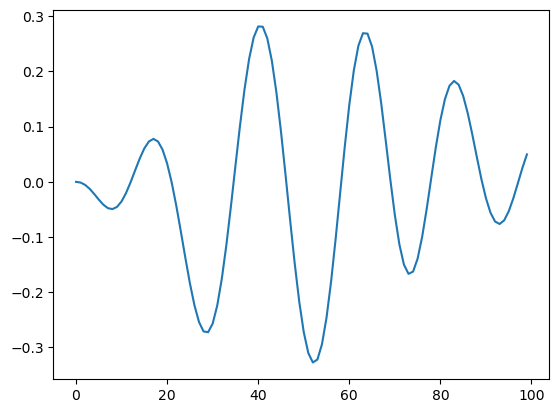

In [20]:
plt.plot(thetas[0])

In [34]:
batches = [] # [(thetas, video), ...]
for i in range(num_batches):
    batches.append(generate_batch(batch_size, gp_extrap_time, dt, length_scale, variance, px, py, wind_scale, g, l, m, theta0s, vel0s, nat_freq, damp_ratio))  
thetas, videos = map(np.concatenate, zip(*batches))

In [35]:
# sparse_step = 2
# norm_step = int(gp_norm_time / dt / subsample_step_size)

# sparse_thetas = thetas[:, :norm_step:sparse_step]
# sparse_videos = videos[:, :norm_step:sparse_step]

# norm_thetas = thetas[:, :norm_step]
# norm_videos = videos[:, :norm_step] 

In [36]:
# Create data batches
# Sparse_Batches = (sparse_thetas, sparse_videos)
# with open("../Data/Sparse_Batches.pkl", "wb") as f:
#     pickle.dump(Sparse_Batches, f)

# Norm_Batches = (norm_thetas, norm_videos)
# with open("../Data/Norm_Batches.pkl", "wb") as f:
#     pickle.dump(Norm_Batches, f)
 
Dataset = (thetas, videos)
# with open("../Data/Dataset.pkl", "wb") as f:
#     pickle.dump({
#         "dt": dt*subsample_step_size, 
#         "dataset": Dataset
#     }, f) 

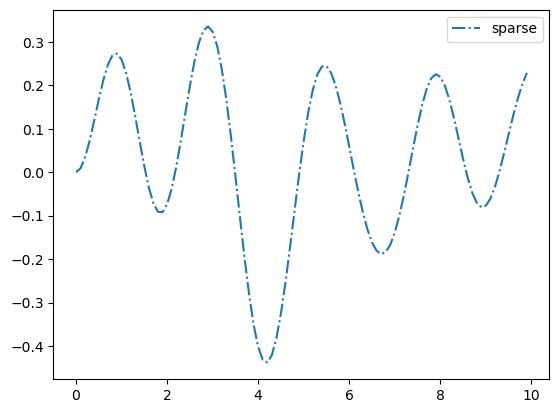

In [37]:
line_types = ['-', '--', '-.'] 
# plt.plot(np.arange(0, gp_norm_time, sparse_step*(dt*subsample_step_size)), sparse_thetas[0, :, 0].T, linestyle=line_types[0])
# plt.plot(np.arange(0, gp_norm_time, (dt*subsample_step_size)), norm_thetas[0, :, 0].T, linestyle=line_types[1])
plt.plot(np.arange(0, gp_extrap_time, (dt*subsample_step_size)), thetas[0, :, 0].T, linestyle=line_types[2])
plt.legend(['sparse', 'normal', 'extrapolated'])
plt.show()

In [ ]:
cmap = plt.cm.Blues
cmap = cmap(np.linspace(0, 1, cmap.N))
cmap[:1, -1] = 0  
transparent_cmap = mcolors.ListedColormap(cmap)
def make_heatmap(video, video_title):
    def heatmap(batch):
        video = np.array([t*v for t,v in enumerate(batch, start=1)])
        flat_video = np.max(video, 0)
        flat_video = 0.5 + flat_video / np.max(flat_video)  
        return flat_video
        
    fig, axs = plt.subplots(4,4)  
    for i in range(4):
        for j in range(4):
            index = i*4+j 
            if index >= len(video):
                break
            heat_img = heatmap(video[index,:,:,:])
            axs[i,j].imshow(heat_img, cmap=transparent_cmap)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
        if index >= len(video):
            break
    fig.suptitle(video_title)
    fig.show()
    
video_titles = ["Sparse", "Normal", "Extrapolated_Kernel"]
# for i in range(len(videos)):
make_heatmap(video, video_titles[2])

In [ ]:
def get_coords(th):
    return l * np.sin(th), -l * np.cos(th) 
    
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
x0, y0 = get_coords(theta0)
bob_radius = 0.08
line, = ax.plot([0, x0], [0, y0], lw=3, c='k')
line.set_data([0, x0], [0, y0])
circle = ax.add_patch(plt.Circle(get_coords(theta0), bob_radius, fc='black', zorder=3))
ax.set_xlim(-l*1.2, l*1.2)
ax.set_ylim(-l*1.2, 0)

def make_animation(theta, video_title, time, fps):
    nframes = time * fps
    prog = iter(tqdm(iter(range(nframes+1)), total=nframes))
    def animate(i):
        next(prog)
        x, y = get_coords(theta[int(i/nframes*len(theta))])
        line.set_data([0, x], [0, y])
        circle.set_center((x, y))
     
    ani = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True, interval=1000/fps)
    plt.ion()
    plt.show()
    writervideo = animation.PillowWriter(fps=fps) 
    ani.save(f'../Gifs/{video_title}.gif', writer=writervideo) 

video_titles = [ "Sparse_GpOde", "NormalGpOde", "ExtrapolatedGpOde"]
thetas = [sparse_thetas, norm_thetas, thetas]
times = [gp_norm_time, gp_norm_time, gp_extrap_time]
for i in range(len(thetas)):
    make_animation(thetas[i][0,:,0], video_titles[i], times[i], fps)

plt.close()